In [1]:
from PIL import Image, ImageFont, ImageDraw

In [493]:
import mistune
import re
import random
import pandas as pd
import os

In [435]:
from faker import Faker

In [615]:
politician = pd.read_csv('data/TWFU-PoliticianData.csv', skiprows=1)

In [707]:
class DocTemplate:
    def __init__(self,):
        template_fpath = [os.path.join('templates', fname)
                          for fname in os.listdir('templates/')
                          if fname.endswith('.md')]
        self.templates = [open(fp).read() for fp in template_fpath]
    def gen(self):
        return random.choice(self.templates)

In [760]:
def get_token_text(token):
    assert token[0] == '{' and token[-1] == '}'
    token = token[1:-1]
    if token == 'number':
        if random.random() > 0.5:
            return str(random.randint(0, 50))
        return str(random.randint(0, 1000))
    if token == 'pm_id':
        return '%03d' % random.randint(0, 1000)
    if token == 'pm_name_lastname':
        if random.random() > 0.5:
            sample = politician.sample(3)
            title = sample.iloc[0]['title']
            name = sample.iloc[1]['name']
            lastname = sample.iloc[2]['lastname']
        else:
            faker=Faker('th')
            title = random.choice(['นาย', 'นาง', 'นางสาว'])
            name = faker.first_name()
            lastname = faker.last_name()
        return f'{title}{name} {lastname}'
    if token == 'party':
        text = politician[~politician.party.isna()].party.sample().iloc[0]
        return text
    if token == 'vote':
        return random.choice(['เห็นด้วย', 'ไม่เห็นด้วย', 'เห็นไม่ด้วย', '-'])
    if token == 'phonenumber_th':
        faker=Faker('th')
        return faker.phone_number()
    if token == 'month':
        faker=Faker('th')
        return faker.month_name()
    return 'dummy'
    
def get_doc_md(template):
    """return markdown text"""
    tokens = re.findall('\{[^\}]*\}', template)
    for token in tokens:
        template=template.replace(token, get_token_text(token), 1)
    return template

def get_font():
    return ImageFont.truetype('fonts/THSarabun.ttf', size=18)

def create_paper(
    width=826,
    height=1169,
    color='#fff'
):
    return Image.new('RGB', (width, height,), color)


def put_text(canvas, x, y, text, font):
    words = text.split()
    curr_x = x
    word_bbox = []
    for i in range(len(words)):
        word = words[i]
        canvas.text((curr_x, y), word, fill='black', font=font)
        
        bbox = canvas.textbbox((curr_x, y), word, font=font)
        word_bbox.append({'bbox': bbox, 'text': word})
        w = font.getlength(word)
        curr_x += w
        if i+1 < len(words):
            curr_x += font.getlength(' ')

    return word_bbox


def generate():
    markdown_parser = mistune.create_markdown(plugins=['table'], renderer='ast')
    paper = create_paper()
    canvas = ImageDraw.Draw(paper)
    font = get_font()
    doc_template_gen = DocTemplate()
    parsed_components = markdown_parser(get_doc_md(doc_template_gen.gen()))
    line_height = 24
    position_start={'x': 70, 'y': 100}
    curr=position_start.copy()
    
    text_bbox = []
    for component in parsed_components:
        if component['type'] == 'paragraph':
            for c_comp in component['children']:
                #canvas.text(list(curr.values()), c_comp['text'], fill='black', font=font)
                args = {**curr, 'text': c_comp['text'], 'font': font, 'canvas': canvas}
                text_bbox.extend(put_text(**args))
                curr['y'] += line_height

        elif component['type'] == 'table':
            # get number of column
            col_num = None
            col_ratio = []
            ## get config
            for c_comp in component['children']:
                if c_comp['type'] == 'table_head':
                    # count number of columns
                    col_num = len(c_comp['children'])
                    for cell in c_comp['children']:
                        col_ratio.append(float(cell['children'][0]['text']))
                    assert 1 == sum(col_ratio), 'the ratio should add up to 1'
            ####################

            table_start = position_start['x']
            table_size = paper.size[0] - table_start*2
            
            column_widths = [cr*table_size for cr in col_ratio]
            
            for c_comp in component['children']:
                for row in c_comp['children']:
                    # skip header
                    if c_comp['type'] == 'table_head':
                        continue
                    
                    for i, cell in enumerate(row['children']):
                        if len(cell['children']) == 0: continue
                            
                        ## position
                        cell_x_start = sum(column_widths[:i])
                        if i != 0: cell_x_start += 5
                        cell_width = column_widths[i]
                        x = table_start+cell_x_start
                        ####################
                        
                        text = cell['children'][0]['text']
                        
                        ## alignment of text
                        if cell['align'] == 'right':
                            text_w = font.getlength(text)
                            x = x + cell_width - text_w
                        elif cell['align'] == 'center':
                            text_w = font.getlength(text)
                            x = x + cell_width/2 - text_w/2
                        ####################
                        
                        args = {
                                'x': x,
                                'y': curr['y'],
                                'text': text,
                                'font': font,
                                'canvas': canvas
                               }
                        text_bbox.extend(put_text(**args))

                    curr['y'] += line_height
        elif component['type'] == 'block_html':
            tags = re.findall(r'<([^>/]+)/?>', component['text'])
            for tag in tags:
                # if the tag is <br> or <br/> then add line
                if tag == 'br': curr['y'] += line_height
                else: print(tag)
        else:
            print(component)
    return paper, text_bbox

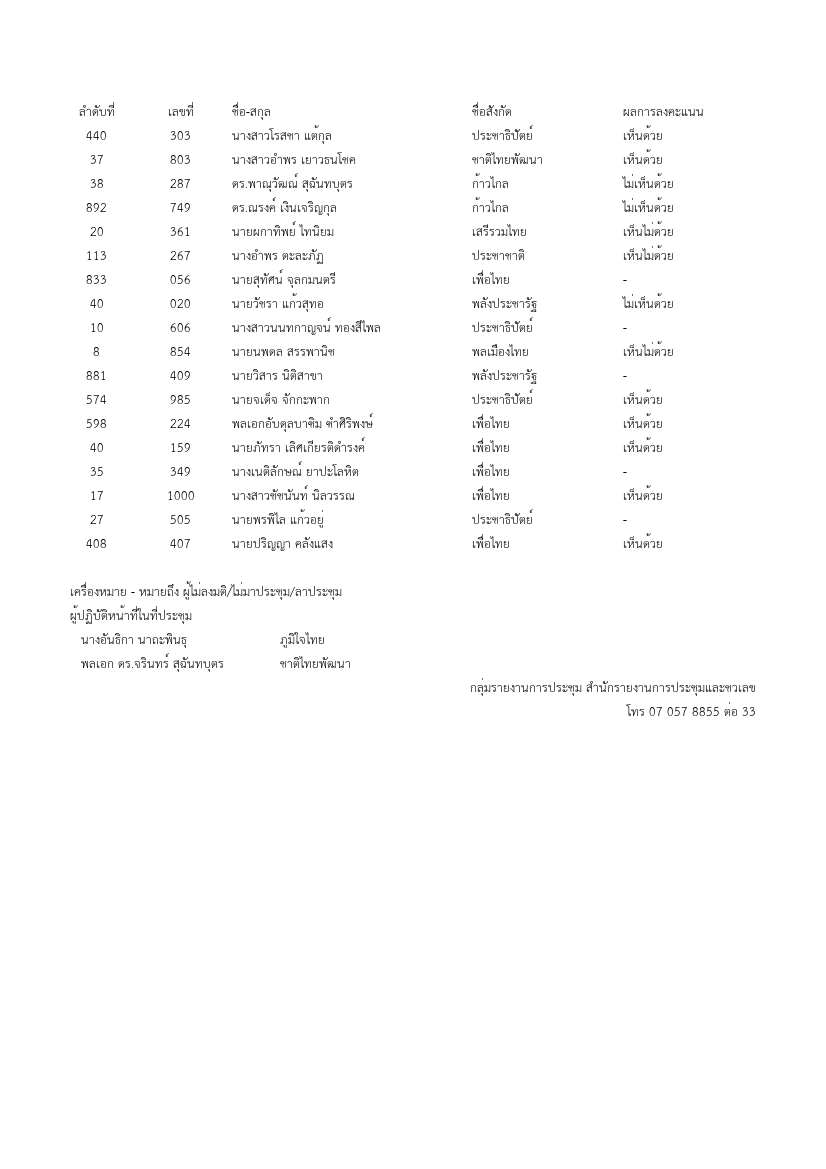

In [761]:
img, bbox = generate()
img

In [775]:
import augraphy as ag
import numpy as np

In [940]:
help(ag.DirtyDrum)

Help on class DirtyDrum in module augraphy.augmentations.dirtydrum:

class DirtyDrum(augraphy.base.augmentation.Augmentation)
 |  DirtyDrum(line_width_range=(1, 4), line_concentration=0.1, direction=-1, noise_intensity=0.5, noise_value=(0, 30), ksize=(3, 3), sigmaX=0, p=1)
 |  
 |  Emulates dirty drum effect by creating stripes of vertical and
 |  horizontal noises.
 |  
 |  :param line_width_range: Pair of ints determining the range from which the
 |         width of a dirty drum line is sampled.
 |  :type line_width_range: tuple, optional
 |  :param line_concentration: Concentration or number of dirty drum lines.
 |  :type line_concentration: float, optional
 |  :param direction: Direction of effect, -1=random, 0=horizontal, 1=vertical, 2=both.
 |  :type direction: int, optional
 |  :param noise_intensity: Intensity of dirty drum effect, recommended value
 |         range from 0.8 to 1.0.
 |  :type noise_intensity: float, optional
 |  :param noise_value: Tuple of ints to determine va

In [1402]:
pipeline = ag.AugmentationSequence([
    ag.LowInkRandomLines(),
    ag.PencilScribbles(size_range=(10, 50),stroke_count_range=(1,2), count_range=(1,5), thickness_range=(1,2), p=.8),
    ag.Gamma(gamma_range=(.1,.3)),
    ag.LowInkPeriodicLines(),
])

In [1410]:
[x*1.4 for x in [826, 1169]]

[1156.3999999999999, 1636.6]